In [77]:
from dotenv import load_dotenv
load_dotenv()

True

In [4]:
import pandas as pd

file_path = ('01_District_wise_crimes_committed_IPC_2001_2012.csv') # insert the path of the csv file
data = pd.read_csv(file_path)

#preview the csv file
data.head()

,STATE/UT,DISTRICT,YEAR,MURDER,ATTEMPT TO MURDER,CULPABLE HOMICIDE NOT AMOUNTING TO MURDER,RAPE,CUSTODIAL RAPE,OTHER RAPE,KIDNAPPING & ABDUCTION,...,ARSON,HURT/GREVIOUS HURT,DOWRY DEATHS,ASSAULT ON WOMEN WITH INTENT TO OUTRAGE HER MODESTY,INSULT TO MODESTY OF WOMEN,CRUELTY BY HUSBAND OR HIS RELATIVES,IMPORTATION OF GIRLS FROM FOREIGN COUNTRIES,CAUSING DEATH BY NEGLIGENCE,OTHER IPC CRIMES,TOTAL IPC CRIMES
0,ANDHRA PRADESH,ADILABAD,2001,101,60,17,50,0,50,46,...,30,1131,16,149,34,175,0,181,1518,4154
1,ANDHRA PRADESH,ANANTAPUR,2001,151,125,1,23,0,23,53,...,69,1543,7,118,24,154,0,270,754,4125
2,ANDHRA PRADESH,CHITTOOR,2001,101,57,2,27,0,27,59,...,38,2088,14,112,83,186,0,404,1262,5818
3,ANDHRA PRADESH,CUDDAPAH,2001,80,53,1,20,0,20,25,...,23,795,17,126,38,57,0,233,1181,3140
4,ANDHRA PRADESH,EAST GODAVARI,2001,82,67,1,23,0,23,49,...,41,1244,12,109,58,247,0,431,2313,6507


In [5]:
from langchain_community.document_loaders.csv_loader import CSVLoader
loader = CSVLoader(file_path=file_path)
doc_splits = loader.load_and_split()

In [6]:
from langchain_community.vectorstores import Chroma
from langchain_google_genai import GoogleGenerativeAIEmbeddings

vectorstore = Chroma.from_documents(
    documents=doc_splits,
    collection_name="rag-chroma",
    embedding=GoogleGenerativeAIEmbeddings(model='models/embedding-001'),
    persist_directory="chroma_vdb"
)

/Users/apitchai002/Documents/Clones/crraimscs-genai-2025/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
retriever = vectorstore.as_retriever()

In [8]:
from langchain.tools.retriever import create_retriever_tool

retriever_tool = create_retriever_tool(
    retriever,
    "retrieve_csv_file",
    "Search and return information about crimes from the csv files.",
)

In [80]:
from langchain_community.tools import TavilySearchResults

internet_search_tool = TavilySearchResults(
    max_results=5,
    search_depth="advanced",
    include_answer=True,
    include_raw_content=True,
    include_images=True,
    
)
internet_search_tool.invoke({"query": "What happened at the last wimbledon"})

[{'url': 'https://www.tennis365.com/tennis-features/wimbledon-what-happened-the-two-previous-times-novak-djokovic-received-a-walkover-at-grand-slams',
  'content': "Novak Djokovic received a walkover at a Grand Slam tournament for the third time in his career when Alex de Minaur withdrew ahead of the pair's Wimbledon quarter-final. World No 9 de Minaur suffered a hip injury near the end of his four-set last 16 victory against Arthur Fils and pulled out on the day of his match with Djokovic."},
 {'url': 'https://www.thetennisgazette.com/features/i-beat-roger-federer-in-his-last-ever-match-at-wimbledon-and-now-ive-won-eight-atp-titles/',
  'content': 'What happened to Hubert Hurkacz after beating Roger Federer at Wimbledon? After scoring the biggest win of his career at Wimbledon, Hurkacz established himself as a top-ten talent on the ATP Tour. The Pole finished the year ninth, tenth, and ninth again from 2021-2023, before regressing slightly in 2024 as he currently sits ranked 16th in t

In [97]:
from typing import Annotated, Sequence
from typing_extensions import TypedDict
from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages

class AgentState(TypedDict):
    # The add_messages function defines how an update should be processed
    # Default is to replace. add_messages says "append"
    messages: Annotated[Sequence[BaseMessage], add_messages]

In [98]:
from langchain_google_genai import ChatGoogleGenerativeAI

def agent(state):
    """
    Invokes the agent model to generate a response based on the current state. Given
    the question, it will decide to retrieve using the retriever tool.

    Args:
        state (messages): The current state

    Returns:
        dict: The updated state with the agent response appended to messages
    """
    print("---CALL AGENT---")
    messages = state["messages"]
    model = ChatGoogleGenerativeAI(temperature=0.5, model="gemini-2.0-flash-exp", streaming=True)
    tools = [retriever_tool]
    model_with_tools = model.bind_tools(tools)
    response = model_with_tools.invoke(messages)
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}

In [99]:
from typing import Literal
from langchain_core.prompts import PromptTemplate
from pydantic import BaseModel, Field

def grade_documents(state) -> Literal["generate", "redo"]:
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (messages): The current state

    Returns:
        str: A decision for whether the documents are relevant or not
    """
    print("---CHECK RELEVANCE---")
    # Data model
    class grade(BaseModel):
        """Binary score for relevance check."""
        binary_score: str = Field(description="Relevance score 'yes' or 'no'")
    # LLM
    model = ChatGoogleGenerativeAI(temperature=0.5, model="gemini-2.0-flash-exp", streaming=True)
    # LLM with structured output for validation
    structured_llm = model.with_structured_output(grade)
    # Prompt
    prompt = PromptTemplate(
        template="""You are a grader assessing relevance of a retrieved document to a user question. \n 
        Here is the retrieved document: \n\n {context} \n\n
        Here is the user question: {question} \n
        If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
        Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question.""",
        input_variables=["context", "question"],
    )
    # Chain
    chain = prompt | structured_llm
    messages = state["messages"]
    last_message = messages[-1]
    question = messages[0].content
    docs = last_message.content
    scored_result = chain.invoke({"question": question, "context": docs})
    score = scored_result.binary_score
    if score == "yes":
        print("---DECISION: DOCS RELEVANT---")
        return "generate"
    else:
        print("---DECISION: DOCS NOT RELEVANT---")
        print(score)
        return "redo"

In [100]:
from langchain_google_genai import ChatGoogleGenerativeAI

def redo(state):
    """
    Invokes the agent model to generate a response based on the current state. Given
    the question, it will decide to retrieve using the internet search tool.

    Args:
        state (messages): The current state

    Returns:
        dict: The updated state with the agent response appended to messages
    """
    print("---CALL AGENT---")
    messages = state["messages"]
    question = messages[0].content
    model = ChatGoogleGenerativeAI(temperature=0.5, model="gemini-2.0-flash-exp", streaming=True)
    tools = [internet_search_tool]
    model_with_tools = model.bind_tools(tools)
    response = model_with_tools.invoke(question)
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}

In [101]:
from langchain import hub
from langchain_core.output_parsers import StrOutputParser

def generate(state):
    """
    Generate answer

    Args:
        state (messages): The current state

    Returns:
         dict: The updated state with answer to the question
    """
    print("---GENERATE---")
    messages = state["messages"]
    question = messages[0].content
    last_message = messages[-1]
    docs = last_message.content
    # Prompt
    prompt = hub.pull("rlm/rag-prompt")
    # LLM
    llm = ChatGoogleGenerativeAI(temperature=0.5, model="gemini-2.0-flash-exp", streaming=True)
    # # Post-processing
    # def format_docs(docs):
    #     return "\n\n".join(doc.page_content for doc in docs)
    # Chain
    rag_chain = prompt | llm | StrOutputParser()
    # Run
    response = rag_chain.invoke({"context": docs, "question": question})
    return {"messages": [response]}

In [102]:
from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

# Define a new graph
workflow = StateGraph(AgentState)

In [103]:
# Define the nodes we will cycle between
workflow.add_node("agent", agent)  # agent
retrieve = ToolNode([retriever_tool])
workflow.add_node("retrieve", retrieve)  # retrieval
workflow.add_node("redo", redo)  # searching the internet
search = ToolNode([internet_search_tool])
workflow.add_node("search", search)
workflow.add_node("generate", generate)  # Generating a response after we know the documents are relevant
workflow.add_edge(START, "agent")

In [104]:
# Decide whether to retrieve
workflow.add_conditional_edges(
    "agent",
    # Assess agent decision
    tools_condition,
    {
        # Translate the condition outputs to nodes in our graph
        "tools": "retrieve",
        END: END,
    },
)

# Edges taken after the `action` node is called.
workflow.add_conditional_edges(
    "retrieve",
    # Assess agent decision
    grade_documents,
)

In [105]:
# Decide whether to search internet
workflow.add_conditional_edges(
    "redo",
    # Assess redo agent decision
    tools_condition,
    {
        # Translate the condition outputs to nodes in our graph
        "tools": "search",
        END: END,
    },
)

In [106]:
workflow.add_edge("generate", END)
workflow.add_edge("search", "generate")

# Compile
graph = workflow.compile()

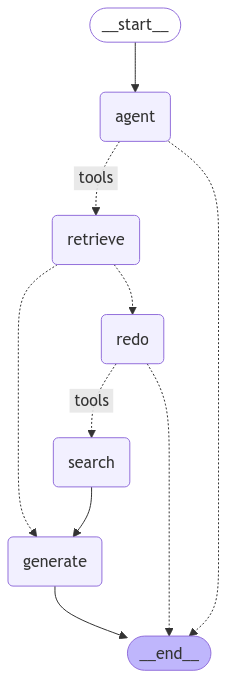

In [107]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [108]:
import pprint

inputs = {
    "messages": [
        ("user", "How many murders happened in CHENNAI in 2001?"),
    ]
}

In [109]:
for output in graph.stream(inputs):
    for key, value in output.items():
        pprint.pprint(f"Output from node '{key}':")
        pprint.pprint("---")
        pprint.pprint(value, indent=2, width=80, depth=None)
    pprint.pprint("\n---\n")

---CALL AGENT---
"Output from node 'agent':"
'---'
{ 'messages': [ AIMessage(content='', additional_kwargs={'function_call': {'name': 'retrieve_csv_file', 'arguments': '{"query": "How many murders happened in CHENNAI in 2001"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': [{'category': 'HARM_CATEGORY_HATE_SPEECH', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_DANGEROUS_CONTENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HARASSMENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_SEXUALLY_EXPLICIT', 'probability': 'NEGLIGIBLE', 'blocked': False}]}, id='run-8972a09c-a6d6-4a29-a488-810aa2129319-0', tool_calls=[{'name': 'retrieve_csv_file', 'args': {'query': 'How many murders happened in CHENNAI in 2001'}, 'id': '26aa2a52-52ea-4ce7-b753-5c4db194e447', 'type': 'tool_call'}], usage_metadata={'input_tokens': 66, 'output_

/Users/apitchai002/Documents/Clones/crraimscs-genai-2025/.venv/lib/python3.9/site-packages/langsmith/client.py:256: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


"Output from node 'generate':"
'---'
{ 'messages': [ 'In 2001, there were 91 murders reported in Chennai. The data '
                'shows that there were 91 murders in Chennai in 2001. This '
                'information is based on the provided context.']}
'\n---\n'


In [114]:
inputs = {
    "messages": [
        ("user", "Write about any crime happened in Chennai in 2024"),
    ]
}

In [115]:
for output in graph.stream(inputs):
    for key, value in output.items():
        pprint.pprint(f"Output from node '{key}':")
        pprint.pprint("---")
        pprint.pprint(value, indent=2, width=80, depth=None)
    pprint.pprint("\n---\n")

---CALL AGENT---
"Output from node 'agent':"
'---'
{ 'messages': [ AIMessage(content='', additional_kwargs={'function_call': {'name': 'retrieve_csv_file', 'arguments': '{"query": "crime in Chennai in 2024"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': [{'category': 'HARM_CATEGORY_HATE_SPEECH', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_DANGEROUS_CONTENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HARASSMENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_SEXUALLY_EXPLICIT', 'probability': 'NEGLIGIBLE', 'blocked': False}]}, id='run-38f0876f-bfcd-400a-98f9-01e1aa0c91ad-0', tool_calls=[{'name': 'retrieve_csv_file', 'args': {'query': 'crime in Chennai in 2024'}, 'id': '9a853b27-d292-4a32-a12f-316d8ee36474', 'type': 'tool_call'}], usage_metadata={'input_tokens': 64, 'output_tokens': 15, 'total_tokens': 79, 'input_

/Users/apitchai002/Documents/Clones/crraimscs-genai-2025/.venv/lib/python3.9/site-packages/langsmith/client.py:256: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


"Output from node 'generate':"
'---'
{ 'messages': [ 'In 2024, the Avadi Police Commissionerate has seen a decrease '
                'in crimes, including murders, compared to 2023. However, a '
                'man named Gnanasekaran was arrested in December 2024 for '
                'raping an engineering student at Anna University. '
                'Additionally, major crimes like murder for gain, robbery, and '
                'burglary have decreased in Chennai.']}
'\n---\n'
